<a href="https://colab.research.google.com/github/alfariziraju/Praktek-Fuzzy-G211220061/blob/main/Praktek_Fuzzy_ANFIS_G211220061.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.0 MB/s eta 0:00:00
Data Sample:
           RPM       Load       Temp
0  3247.240713  23.514805  39.314558
1  6704.285838  32.287227  52.131395
2  5391.963651  24.160839  44.952357
3  4591.950905  17.096203  43.972864
4  1936.111843  19.650870  30.377152


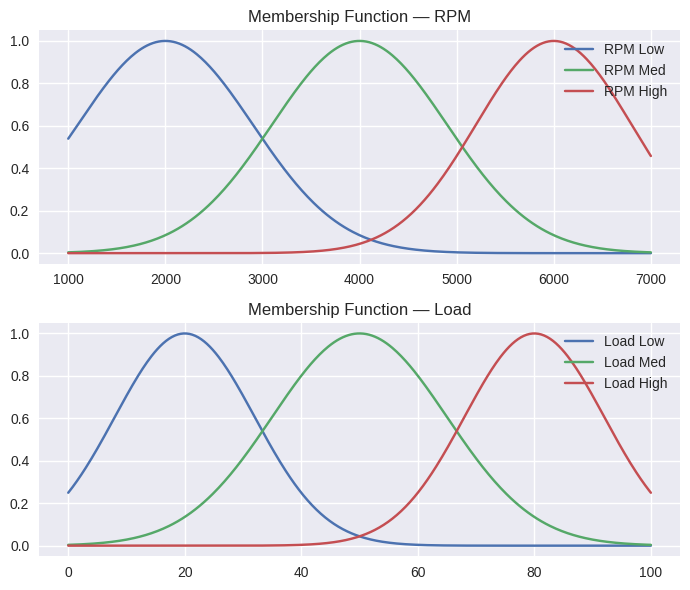

Epoch 5/30 Loss: 1.3987
Epoch 10/30 Loss: 1.3987
Epoch 15/30 Loss: 1.3987
Epoch 20/30 Loss: 1.3987
Epoch 25/30 Loss: 1.3987
Epoch 30/30 Loss: 1.3987


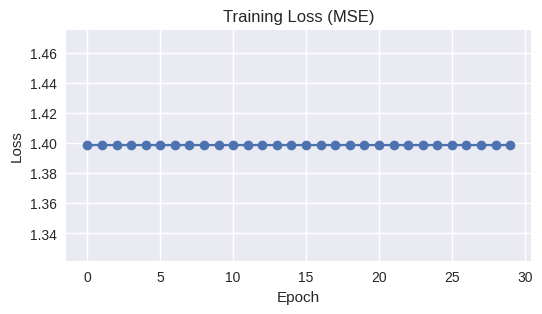


--- Hasil Evaluasi Test Set ---
MSE (Mean Squared Error): 1.5344028477813418
R² (R-squared Score): 0.9747184494330132


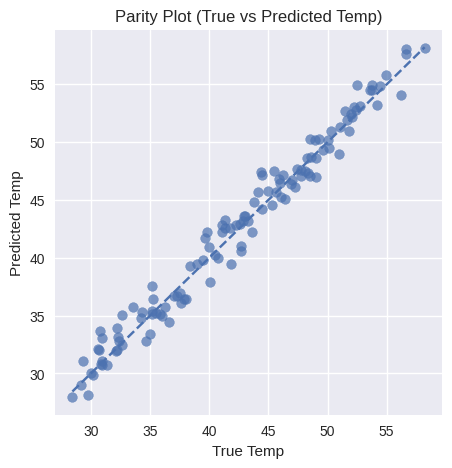


Data Sample dengan Prediksi:
             RPM       Load       Temp  Temp_Pred
433  1606.736057  19.645351  31.476233  30.805565
150  6449.595316  19.351843  51.460469  49.788386
12   5994.655845  60.232031  50.502364  52.327957
492  2664.287098  58.618944  39.365899  38.371429
295  4133.459560  26.398744  41.448827  40.838735
228  6352.279331  69.000100  53.771060  54.914395
566  3353.464271  76.570734  44.954980  43.362549
192  6402.508343  50.471094  54.146842  53.199707
486  1272.678282  59.072911  32.304662  34.175700
186  5903.333201  56.671344  51.433652  51.521619


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install scikit-fuzzy
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Styling dan Seed
plt.style.use("seaborn-v0_8")
np.random.seed(42)

# --- 1. Pembuatan Data Sintetis ---
N = 600
RPM = np.random.uniform(1000, 7000, N)
Load = np.random.uniform(10, 90, N)

# Rumus target Suhu (Temp) dengan noise
Temp = (
    30
    + 0.004 * (RPM - 2000)
    + 0.09 * Load
    + 0.5 * np.sin((RPM / 7000) * 2 * np.pi)
    + 0.02 * Load * (RPM / 7000)
    + np.random.normal(0, 1.2, N)
)

data = pd.DataFrame({"RPM": RPM, "Load": Load, "Temp": Temp})
print("Data Sample:")
print(data.head())


# --- 2. Definisi Fungsi Keanggotaan dan Visualisasi ---

# Fungsi keanggotaan RPM (Gaussian)
x_rpm = np.linspace(1000, 7000, 400)
rpm_low = fuzz.gaussmf(x_rpm, 2000, 900)
rpm_med = fuzz.gaussmf(x_rpm, 4000, 900)
rpm_high = fuzz.gaussmf(x_rpm, 6000, 800)

# Fungsi keanggotaan Load (Gaussian)
x_load = np.linspace(0, 100, 400)
load_low = fuzz.gaussmf(x_load, 20, 12)
load_med = fuzz.gaussmf(x_load, 50, 15)
load_high = fuzz.gaussmf(x_load, 80, 12)

# Visualisasi Fungsi Keanggotaan
fig, ax = plt.subplots(2, 1, figsize=(7, 6))

# Plot RPM
ax[0].plot(x_rpm, rpm_low, label="RPM Low")
ax[0].plot(x_rpm, rpm_med, label="RPM Med")
ax[0].plot(x_rpm, rpm_high, label="RPM High")
ax[0].legend(loc='upper right')
ax[0].set_title("Membership Function — RPM")

# Plot Load
ax[1].plot(x_load, load_low, label="Load Low")
ax[1].plot(x_load, load_med, label="Load Med")
ax[1].plot(x_load, load_high, label="Load High")
ax[1].legend(loc='upper right')
ax[1].set_title("Membership Function — Load")

plt.tight_layout()
plt.show()

# --- 3. Arsitektur Kelas ANFIS Manual ---

class ANFISManual:
    def __init__(self, n_inputs=2, n_mfs=3, lr=0.02):
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.lr = lr # Learning rate (tidak digunakan di LSTSQ)

        # Inisialisasi parameter fungsi keanggotaan (Centers dan Sigmas)
        # Catatan: Inisialisasi ini dilakukan pada data yang sudah dinormalisasi (0-1)
        self.centers = np.array([
            np.linspace(0.1, 0.9, n_mfs) for _ in range(n_inputs)
        ])
        self.sigmas = np.array([
            np.ones(n_mfs) * 0.15 for _ in range(n_inputs)
        ])

        # Inisialisasi parameter konsekuen (w) untuk model Sugeno Orde-1 (linear)
        # Jumlah aturan = n_mfs ^ n_inputs = 3^2 = 9 aturan
        self.n_rules = n_mfs ** n_inputs

        # Menciptakan kombinasi indeks aturan (misal: R1(Low, Low), R2(Low, Med), ...)
        grids = np.meshgrid(*[np.arange(n_mfs) for _ in range(n_inputs)])
        self.rule_indices = np.vstack([g.flatten() for g in grids]).T

        # Inisialisasi parameter konsekuen (p, q, r)
        # Bentuk: (jumlah aturan, jumlah input + 1)
        # Jika n_inputs=2, maka (9, 3) -> p*x1 + q*x2 + r
        self.W = np.zeros((self.n_rules, n_inputs + 1))


    # Fungsi keanggotaan Gaussian
    def _gauss(self, x, c, s):
        # Menggunakan bentuk e^(-0.5 * ((x-c)/s)^2)
        return np.exp(-0.5 * ((x - c) / s) ** 2)

    # Lapisan Firing Strength (Layer 2)
    def _firing(self, Xn):
        N = Xn.shape[0]
        F = np.zeros((N, self.n_rules))

        for r in range(self.n_rules):
            prod = np.ones(N)
            for i in range(self.n_inputs):
                idx = self.rule_indices[r, i]
                # Menghitung derajat keanggotaan dan mengalikannya (AND operator)
                prod *= self._gauss(Xn[:, i], self.centers[i, idx], self.sigmas[i, idx])
            F[:, r] = prod
        return F

    # Lapisan Output (Layer 4 & 5)
    def predict(self, Xn):
        F = self._firing(Xn) # Firing strength

        # Normalisasi firing strength (Wn - Normalized Firing Strength)
        Wn = F / (F.sum(1, keepdims=True) + 1e-8)

        # Input yang diperluas [x1, x2, 1]
        Xext = np.hstack([Xn, np.ones((Xn.shape[0], 1))])

        # Hitung output tiap aturan: y_rules = Xext * W.T
        y_rules = Xext @ self.W.T

        # Agregasi (Weighted Average): y = sum(Wn * y_rules)
        y = (Wn * y_rules).sum(axis=1, keepdims=True)

        return y, F, Wn

    # Proses Pelatihan (Adaptasi/Fitting)
    def fit(self, Xn, y, epochs=30):
        history = []
        N = Xn.shape[0]

        for ep in range(epochs):
            # Fase 1: Forward Pass (menghitung Wn dan Phi)
            F = self._firing(Xn)
            Wn = F / (F.sum(1, keepdims=True) + 1e-8)
            Xext = np.hstack([Xn, np.ones((N, 1))])

            # Matriks Phi untuk LSTSQ (memasukkan Wn ke dalam Xext)
            # Bentuk Phi: (N, n_rules * (n_inputs + 1))
            Phi = np.zeros((N, self.n_rules * (self.n_inputs + 1)))

            for r in range(self.n_rules):
                s = r * (self.n_inputs + 1)
                # Phi = Wn * Xext
                Phi[:, s:s + self.n_inputs + 1] = Wn[:, r:r + 1] * Xext

            # Fase 2: Backward Pass (Penentuan parameter konsekuen W)
            # Menyelesaikan sistem persamaan linear (least-squares)
            Theta, residuals, rank, s_vals = np.linalg.lstsq(Phi, y, rcond=None)
            self.W = Theta.reshape(self.n_rules, self.n_inputs + 1)

            # Hitung Loss
            y_pred, _, _ = self.predict(Xn)
            loss = ((y - y_pred) ** 2).mean() # Mean Squared Error (MSE)
            history.append(loss)

            if (ep + 1) % 5 == 0:
                print(f"Epoch {ep+1}/{epochs} Loss: {loss:.4f}")

        # Catatan: ANFIS sejati juga memperbarui Centers dan Sigmas (Fuzzy Premise)
        # melalui Gradient Descent, tetapi implementasi ini hanya menggunakan LSTSQ
        # untuk memperbarui parameter konsekuen (W).

        return history


# --- 4. Pelatihan dan Evaluasi ---

# Data input dan target
X = data[['RPM', 'Load']].values
Y = data['Temp'].values.reshape(-1, 1)

# Normalisasi Input (Min-Max)
Xmin = X.min(0)
Xmax = X.max(0)
normalize = lambda X: (X - Xmin) / (Xmax - Xmin + 1e-8)

Xn = normalize(X)

# Split data (Train/Test)
Xtr, Xte, ytr, yte = train_test_split(Xn, Y, test_size=0.2, random_state=42)

# Inisialisasi dan Training ANFIS
anfis = ANFISManual()
history = anfis.fit(Xtr, ytr, epochs=30)


# --- 5. Visualisasi Loss dan Evaluasi Metrik ---

# Plot Training Loss
plt.figure(figsize=(6, 3))
plt.plot(history, marker='o')
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
# Prediksi dan Metrik Evaluasi
y_pred, _, _ = anfis.predict(Xte)

print("\n--- Hasil Evaluasi Test Set ---")
print("MSE (Mean Squared Error):", mean_squared_error(yte, y_pred))
print("R² (R-squared Score):", r2_score(yte, y_pred))

# Parity Plot
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, alpha=0.7)
mn, mx = yte.min(), yte.max()
plt.plot([mn, mx], [mn, mx], '--')
plt.xlabel("True Temp")
plt.ylabel("Predicted Temp")
plt.title("Parity Plot (True vs Predicted Temp)")
plt.grid(True)
plt.show()
# Menampilkan data sample dengan prediksi
data['Temp_Pred'] = anfis.predict(normalize(data[['RPM', 'Load']].values))[0].flatten()
print("\nData Sample dengan Prediksi:")
print(data.sample(10))